# Parsing the datasets

### Importing libraries

In [1]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn
# Decimal precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

# Scipy
import scipy
import scipy.stats as stats

# Matplotlib
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
#mpl.rc('figure', figsize=(10, 8))

# DBscan from sklearn
from sklearn import cluster, datasets
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Pandas experiments
import pandas as pd
from pandas import Series, DataFrame, Panel

# Misc
import time
import datetime as dt
import math
import random
print 'All libraries loaded.'

All libraries loaded.


# Make dataframes from data

In [2]:
# Make dataframes from data

# eGFR data
egfr_df = pd.read_csv('~/code/independent/datasets/cdr_gfr_derived.csv', parse_dates=['resultdata'])
egfr_df.drop('gfr', axis=1, inplace=True)
egfr_df.columns = ['pid', 'timestamp', 'gender', 'birthyear', 'age', 'gfr']

# Findings data
findings_df = pd.read_csv('~/code/independent/datasets/cdr_finding.csv', parse_dates=['finddate'], usecols=['idperson', 'finddate', 'valuename', 'findvalnum'])
findings_df = findings_df[['idperson', 'finddate', 'valuename', 'findvalnum']]
findings_df.columns = ['pid', 'timestamp', 'testname', 'testval']

# Lab reports data
lab_df = pd.read_csv('~/code/independent/datasets/cdr_lab_result.csv', parse_dates=['resultdate'], usecols=['idperson', 'resultdate', 'valuename', 'resultvaluenum'])
lab_df = lab_df[['idperson', 'resultdate', 'valuename', 'resultvaluenum']]
lab_df.columns = ['pid', 'timestamp', 'testname', 'testval']
# Make all lab tests values uppercase
lab_df.testname = map(lambda x: x.upper(), lab_df.testname)

In [3]:
# Normalize dates (to remove the time part of it)
egfr_df.timestamp = egfr_df.timestamp.map(pd.datetools.normalize_date)
findings_df.timestamp = findings_df.timestamp.map(pd.datetools.normalize_date)
lab_df.timestamp = lab_df.timestamp.map(pd.datetools.normalize_date)

In [4]:
# NaN values
total_rowcount = len(lab_df.testval.values)
nan_rowcount = len([x for x in lab_df.testval.values if math.isnan(x)])
print '\n',(str(nan_rowcount*100/total_rowcount)+ "% of the values are NaN")

# Drop NaN rows
# lab_df.dropna(inplace=True)


1% of the values are NaN


## Make tiny versions of the datasets

In [5]:
# howmany = 500000

# egfr_df = egfr_df[:howmany]
# lab_df = lab_df[:howmany]
# findings_df = findings_df[:howmany]

## Make a multi-index/hierarchical index 
#### The index will be a combination of the PID (person ID) and timestamp

In [6]:
# Set the index as a combination of the person ID and timestamp
egfr_df.set_index(['pid', 'timestamp'], inplace=True)
findings_df.set_index(['pid', 'timestamp'], inplace=True)
lab_df.set_index(['pid', 'timestamp'], inplace=True)

## Get list of all patients for whom we have eGFR data

In [7]:
list_of_patients = list(set(egfr_df.index.get_level_values('pid').values))
print '\nFound', len(list_of_patients), 'unique patients'


Found 63215 unique patients


## Get small sample of patients

In [8]:
# Get just 5 patients
# list_of_patients = random.sample(list_of_patients, 5)

# list_of_patients = [8555317, 8555928, 8565179]

## Make the new dataframe (empty)

In [9]:
# Column names will be a combination of all the lab test names and finding names
unique_findings = set(findings_df.testname.values)
unique_labtests = set(lab_df.testname.values)
print '\nFindings:', list(unique_findings)
print 'Lab tests:', list(unique_labtests)
final_col_names = np.append(list(unique_findings), list(unique_labtests))


Findings: ['FND_WTLB', 'FND_BPS', 'FND_BPD', 'FND_HTIN']
Lab tests: ['LR_AST', 'LR_MICROCR', 'LR_HDL', 'LR_TRIG', 'LR_A1C', 'LR_CR', 'LR_PTH', 'LR_GLUCNONFAST', 'LR_GLUCFAST', 'LR_LDL', 'LR_GFR', 'LR_VITD 25', 'LR_ALT', 'LR_VITD 1_25', 'LR_PHOS', 'LR_GFR_AFRAMER']


In [10]:
# Row locations in the eGFR dataframe of patients
# locations_of_patients = []
# for patient in list_of_patients:
#     get_loc_result = egfr_df.index.get_loc(patient)
#     locations_of_patients += [i for i,v in enumerate(get_loc_result) if v == True]

# combined_df = DataFrame(egfr_df.iloc[locations_of_patients])
combined_df = pd.DataFrame(egfr_df)

# Add the new columns
for newcol in final_col_names:
    combined_df[newcol] = np.nan

## Fill values into the new dataframe<br>based on joins on the other dataframes

In [13]:
def fill_data(source_df, patient_id):
    
    ############### Could optimize
    locations_of_patients = []
    if str(patient_id) in source_df.index:
        
#         get_loc_result = source_df.index.get_loc(str(patient_id))
#         locations_of_patients += [i for i,v in enumerate(get_loc_result) if v == True]
#         this_patients_data = source_df.iloc[locations_of_patients]
        this_patients_data = source_df.loc[str(patient_id)]

        # We only need data for the dates that exist in the combined DF already 
        # (the ones that have eGFR readings)
        for timestamp in combined_df.loc[patient_id].index:
            if timestamp in this_patients_data.index.get_level_values('timestamp'):
                this_patient = this_patients_data.loc[timestamp]

                # Set the value in the DF for this test
                # Check if there's multiple values for the same timestamp
                if type(this_patient) == pd.core.frame.DataFrame:
                    for i in range(this_patient.testname.size):
                        
                        try:
                            combined_df.loc[(patient_id, timestamp), this_patient.testname[i]] = this_patient.testval[i]
                        except:
                            print 'multivalues for', patient_id
                else:
                    combined_df.loc[(patient_id, timestamp), this_patient.testname] = this_patient.testval

                    
fill_count = 0
start_time = time.time()
lastseen_time = time.time()

for patient_id in list_of_patients:
    
    if fill_count % 500 == 0:
        elapsed_time = time.time() - lastseen_time
        lastseen_time = time.time()
        print 'Data fill for', fill_count, 'patients completed in', '{:.3f}'.format(elapsed_time), 'seconds'
    fill_count += 1
    
#     ########################################## REMOVE
#     if fill_count < 14001:
#         continue
    
    # Check if the findings df has data about this patient
    fill_data(findings_df, patient_id)

    # Check if the lab-tests df has data about this patient
    fill_data(lab_df, patient_id)
    
    
elapsed_time = time.time() - start_time
print 'Task completed in', '{:.3f}'.format(elapsed_time), 'seconds'

Data fill for 0 patients completed in 0.000 seconds
Data fill for 500 patients completed in 157.239 seconds
Data fill for 1000 patients completed in 213.652 seconds
Data fill for 1500 patients completed in 222.478 seconds
Data fill for 2000 patients completed in 185.968 seconds
Data fill for 2500 patients completed in 193.586 seconds
Data fill for 3000 patients completed in 312.431 seconds
Data fill for 3500 patients completed in 286.072 seconds
Data fill for 4000 patients completed in 108.058 seconds
Data fill for 4500 patients completed in 216.104 seconds
Data fill for 5000 patients completed in 200.301 seconds
Data fill for 5500 patients completed in 167.326 seconds
Data fill for 6000 patients completed in 189.163 seconds
Data fill for 6500 patients completed in 159.524 seconds
Data fill for 7000 patients completed in 173.184 seconds
Data fill for 7500 patients completed in 202.893 seconds
Data fill for 8000 patients completed in 201.204 seconds
Data fill for 8500 patients completed

## Fill in smoking status values into the dataframe

In [118]:
# Smoking data
smoke_df = pd.read_csv('~/code/independent/datasets/cdr_history_social.csv', usecols=['idperson', 'valuename'])
smoke_df.columns = ['pid', 'smoker_status']
# Make all lab tests values uppercase
# lab_df.testname = map(lambda x: x.upper(), lab_df.testname)

before_dropping = smoke_df.shape[0]
# Drop duplicate rows 
smoke_df.drop_duplicates(subset='pid', keep='first', inplace=True)
after_dropping = smoke_df.shape[0]
print '\n# of records before dropping duplicates:', before_dropping
print '# of records after dropping duplicates:', after_dropping

# Set the patient ID as the index
smoke_df.set_index('pid', inplace=True)


# of records before dropping duplicates: 1059065
# of records after dropping duplicates: 63314


In [194]:
patients_with_smokedata = [x for x in list_of_patients if x in smoke_df.index]
print "\n{:.2f}%".format(len(patients_with_smokedata)*100.0/len(list_of_patients)), 'of the patients have smoking data.'
print 'We will need to impute the missing data for the remaining', "{:.2f}%".format((len(list_of_patients)-len(patients_with_smokedata))*100.0/len(list_of_patients)), 'of the patients.'


90.99% of the patients have smoking data.
We will need to impute the missing data for the remaining 9.01% of the patients.


In [180]:
# Make an empty column for smoker status in the DF
combined_df['smoker_status'] = np.nan

# Fill in smoking status values for all the patients
def set_smoker_status(pid):
    combined_df.loc[(pid), 'smoker_status'] = smoke_df.loc[pid].smoker_status
map(set_smoker_status, patients_with_smokedata)

In [202]:
# Put the eGFR column last, and bring the smoker_status column in into it's place
col_list = combined_df.columns.tolist()
col_list[3] = 'smoker_status'
col_list[-1] = 'gfr'
combined_df = combined_df[col_list]

In [203]:
combined_df

gender  birthyear  age   smoker_status   FND_WTLB  FND_BPS  \
pid     timestamp                                                               
8545332 2006-08-11      F       1924   90  SOC_PastSmoker  152.50000      120   
        2006-11-02      F       1924   90  SOC_PastSmoker  156.00000      118   
        2007-06-05      F       1924   90  SOC_PastSmoker  157.00000      150   
        2010-02-09      F       1924   90  SOC_PastSmoker  163.00000      164   
        2010-08-17      F       1924   90  SOC_PastSmoker  162.00000      135   
        2011-04-13      F       1924   90  SOC_PastSmoker  163.00000      146   
8545333 2007-05-31      F       1941   73   SOC_NonSmoker  147.00000      130   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
8545336 2010-11-18      F       1928   86   SOC_NonSmoker  121.00000      147   
        2011-09-01      F       1928   86   SOC_NonSmoker  113.00000      115   
8545337 2010-10-29      F       1924   90  SOC_PastSmoker        NaN      120   
8545338 2007-10-11      F       1948   66   SOC_NonSmoker  141.00000      140   
8545339 2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
        2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
8545340 2007-04-19      F       1926   88   SOC_NonSmoker  141.00000      140   
        2007-10-01      F       1926   88   SOC_NonSmoker  248.00000      140   
        2007-10-09      F       1926   88   SOC_NonSmoker        NaN      NaN   
        2008-12-18      F       1926   88   SOC_NonSmoker  150.00000      NaN   
8545341 2006-12-06      F       1943   71             NaN  183.00000      132   
        2007-03-26      F       1943   71             NaN  189.00000      118   
8545342 2007-02-20      F       1931   83  SOC_PastSmoker  128.00000      106   
        2007-07-19      F       1931   83  SOC_PastSmoker  128.00000      112   
8545344 2007-11-26      F       1954   60      SOC_Smoker  194.00000      128   
8545345 2009-06-25      F       1950   64  SOC_PastSmoker  295.00000      106   
8545346 2009-01-15      F       1950   64   SOC_NonSmoker  128.00000      139   
8545347 2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
        2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
8545348 2006-08-10      F       1941   73   SOC_NonSmoker  197.00000      180   
        2009-05-04      F       1941   73   SOC_NonSmoker  182.00000      137   
...                   ...        ...  ...             ...        ...      ...   
9581790 2011-05-06      M       1925   89             NaN  107.00136      120   
9581791 2011-08-29      M       1928   86             NaN        NaN      NaN   
9581793 2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-11-08      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-02-15      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-03-01      M       1935   79  SOC_PastSmoker        NaN      NaN   
9581799 2011-06-24      M       1926   88             NaN        NaN      NaN   
9581800 2011-01-06      M       1936   78             NaN        NaN      NaN   
        2011-03-08      M       1936   78             NaN        NaN      NaN   
        2011-08-08      M       1936   78             NaN        NaN      NaN   
        2011-10-18      M       1936   78             NaN        NaN      NaN   
        2012-01-24      M       1936   78             NaN        NaN      NaN   
9581801 2011-03-30      M       1942   72             NaN        NaN      NaN   
        2011-07-20      M       1942   72             NaN        NaN      NaN   
        2011-08-16      M       1942   72             NaN        NaN      NaN   
        2011-11-19      M       1942   72         

## Visualize how much lab-test/findings data <br>we really have corresponding to eGFR data

In [210]:
# How many values are NaNs
how_much_data_missing = []
for col_name in final_col_names:
    total_rowcount = len(combined_df[col_name].values)
    nan_rowcount = len([x for x in combined_df[col_name].values if math.isnan(x)])
    print (str(nan_rowcount*100/total_rowcount)+ "% of the values in " + col_name + ' are NaN')
    how_much_data_missing.append(nan_rowcount*100/total_rowcount)

55% of the values in FND_WTLB are NaN
52% of the values in FND_BPS are NaN
52% of the values in FND_BPD are NaN
71% of the values in FND_HTIN are NaN
31% of the values in LR_AST are NaN
91% of the values in LR_MICROCR are NaN
42% of the values in LR_HDL are NaN
42% of the values in LR_TRIG are NaN
67% of the values in LR_A1C are NaN
0% of the values in LR_CR are NaN
99% of the values in LR_PTH are NaN
15% of the values in LR_GLUCNONFAST are NaN
88% of the values in LR_GLUCFAST are NaN
43% of the values in LR_LDL are NaN
51% of the values in LR_GFR are NaN
95% of the values in LR_VITD 25 are NaN
34% of the values in LR_ALT are NaN
99% of the values in LR_VITD 1_25 are NaN
98% of the values in LR_PHOS are NaN
81% of the values in LR_GFR_AFRAMER are NaN


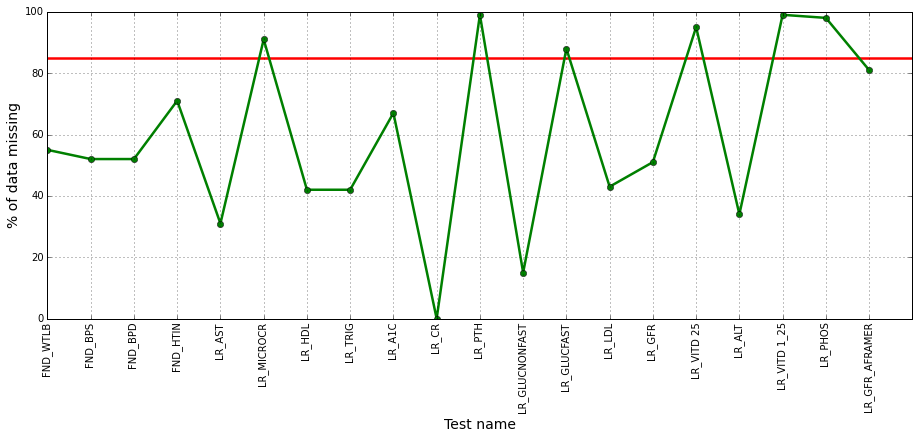

In [250]:
threshold = 85

figure = plt.figure()
figure.set_size_inches(15.5, 5.5)
xaxisvals = [i for i,val in enumerate(final_col_names)]
plt.plot(xaxisvals, how_much_data_missing, linewidth=2.5, c='g', marker='o')
plt.xticks(xaxisvals, final_col_names, rotation=90)
plt.xlabel("Test name", fontsize=14)
plt.ylabel("% of data missing", fontsize=14)
plt.axhline(y=threshold, c="red",linewidth=2.5,zorder=0)
plt.grid()
plt.show()

## Write the resultant DF to a CSV file

In [ ]:
output_file_path = 'combined_df.csv'
combined_df.to_csv(output_file_path, sep='\t')

## Remove columns from the DF for which too much data is missing

#### We don't want to use columns for which too much data is missing. Columns for <br>which the missing data crosses a configured threshold (80% as a heuristic) will be dropped

In [255]:
cols_to_drop = [i for i, val in enumerate(how_much_data_missing) if val > threshold]
# Add offset
cols_to_drop = np.add(cols_to_drop, 4)
print 'Dropping these columns from the DF:\n', combined_df.columns[cols_to_drop].tolist()
combined_df.drop(combined_df.columns[cols_to_drop], axis=1, inplace=True)
print '\nColumns dropped. There are now', combined_df.shape[1], 'columns in the DF'

Dropping these columns from the DF:
['LR_MICROCR', 'LR_PTH', 'LR_GLUCFAST', 'LR_VITD 25', 'LR_VITD 1_25', 'LR_PHOS']

Columns dropped. There are now 19 columns in the DF


In [257]:
# After dropping columns with high amounts of missing data
combined_df

gender  birthyear  age   smoker_status   FND_WTLB  FND_BPS  \
pid     timestamp                                                               
8545332 2006-08-11      F       1924   90  SOC_PastSmoker  152.50000      120   
        2006-11-02      F       1924   90  SOC_PastSmoker  156.00000      118   
        2007-06-05      F       1924   90  SOC_PastSmoker  157.00000      150   
        2010-02-09      F       1924   90  SOC_PastSmoker  163.00000      164   
        2010-08-17      F       1924   90  SOC_PastSmoker  162.00000      135   
        2011-04-13      F       1924   90  SOC_PastSmoker  163.00000      146   
8545333 2007-05-31      F       1941   73   SOC_NonSmoker  147.00000      130   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
8545336 2010-11-18      F       1928   86   SOC_NonSmoker  121.00000      147   
        2011-09-01      F       1928   86   SOC_NonSmoker  113.00000      115   
8545337 2010-10-29      F       1924   90  SOC_PastSmoker        NaN      120   
8545338 2007-10-11      F       1948   66   SOC_NonSmoker  141.00000      140   
8545339 2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
        2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
8545340 2007-04-19      F       1926   88   SOC_NonSmoker  141.00000      140   
        2007-10-01      F       1926   88   SOC_NonSmoker  248.00000      140   
        2007-10-09      F       1926   88   SOC_NonSmoker        NaN      NaN   
        2008-12-18      F       1926   88   SOC_NonSmoker  150.00000      NaN   
8545341 2006-12-06      F       1943   71             NaN  183.00000      132   
        2007-03-26      F       1943   71             NaN  189.00000      118   
8545342 2007-02-20      F       1931   83  SOC_PastSmoker  128.00000      106   
        2007-07-19      F       1931   83  SOC_PastSmoker  128.00000      112   
8545344 2007-11-26      F       1954   60      SOC_Smoker  194.00000      128   
8545345 2009-06-25      F       1950   64  SOC_PastSmoker  295.00000      106   
8545346 2009-01-15      F       1950   64   SOC_NonSmoker  128.00000      139   
8545347 2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
        2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
8545348 2006-08-10      F       1941   73   SOC_NonSmoker  197.00000      180   
        2009-05-04      F       1941   73   SOC_NonSmoker  182.00000      137   
...                   ...        ...  ...             ...        ...      ...   
9581790 2011-05-06      M       1925   89             NaN  107.00136      120   
9581791 2011-08-29      M       1928   86             NaN        NaN      NaN   
9581793 2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-11-08      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-02-15      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-03-01      M       1935   79  SOC_PastSmoker        NaN      NaN   
9581799 2011-06-24      M       1926   88             NaN        NaN      NaN   
9581800 2011-01-06      M       1936   78             NaN        NaN      NaN   
        2011-03-08      M       1936   78             NaN        NaN      NaN   
        2011-08-08      M       1936   78             NaN        NaN      NaN   
        2011-10-18      M       1936   78             NaN        NaN      NaN   
        2012-01-24      M       1936   78             NaN        NaN      NaN   
9581801 2011-03-30      M       1942   72             NaN        NaN      NaN   
        2011-07-20      M       1942   72             NaN        NaN      NaN   
        2011-08-16      M       1942   72             NaN        NaN      NaN   
        2011-11-19      M       1942   72         

## Write the DF (with the low-data columns) to a CSV file

In [259]:
output_file_path = 'combined_df_removedcolumns.csv'
combined_df.to_csv(output_file_path, sep='\t')
print '\nFile write complete.'


File write complete.
